## von Heijne method 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
import re
from scipy.stats import fisher_exact

In [2]:
### FUNCTIONS ###

def get_cleavage_sites(df):
    ''' This functions takes in input a dataframe and select the cleavage sites from the sequences'''
    list_cleavage_sites = list()
    for item, row in df.iterrows():
                cleavage_site = row['Sequence'][(int(row['Signal peptide'])-13):(int(row['Signal peptide'])+2)]
                list_cleavage_sites.append(cleavage_site)
    return list_cleavage_sites

def get_pswm(cleavage_sites):
    '''This function takes in input a list of cleavage sites and computes the PSWM'''

    aa= 'ACDEFGHIKLMNPQRSTVWY'
    pspm = np.ones((15,20))
    for seq in cleavage_sites:
        for i in range(len(seq)):
            if aa.find(seq[i]) != -1:
                pspm[i,aa.find(seq[i])] += 1

    #divide all the counts by N+20=894
    tot = (pspm[1,:]).sum()
    pspm = pspm/tot

    #PSWM
    background_frequencies = np.array([0.0825, 0.0138, 0.0546, 0.0672, 0.0386, 0.0707, 0.0227, 0.0591,0.058 , 0.0965, 0.0241, 0.0406, 0.0474, 0.0393, 0.0553, 0.0665,0.0536, 0.0685, 0.011 , 0.0292])
    pswm = np.ones((15, 20))
    for j in range(pspm.shape[1]):
        pswm[:,j] = np.around(np.log2(pspm[:,j]/background_frequencies[j]), decimals=2)

    return pswm

def get_scores(pswm, df):
    '''This function takes in input a PSWM and a dataframe, slides on each sequence, scores each window and stores the best score for each sequence. Eventually, it returns the dataframe uptaded with the scores'''
    aa= 'ACDEFGHIKLMNPQRSTVWY'
    for item, row in df.iterrows():
        max_score = -999
        seq = row['Sequence']

        if len(seq) < 90:
            final_index = len(seq)-15 + 1
        else:
            final_index = 90 - 15 + 1
        for i in range(final_index):
            score = 0
            for j in range(15):
                if aa.find(seq[i+j]) != -1:
                    score += pswm[j,aa.find(seq[i+j])]
            max_score = max(max_score,score)

        df.at[item, 'score'] = max_score
    
    return df

def avg_sem(original_df):
    means = original_df.iloc[:, :-1].mean()
    stds = original_df.iloc[:, :-1].sem()

    decimal_places = 2
    new_data = {}
    for column in original_df.columns[1:-1]:
        mean_std_str = f"{means[column]:.{2}f} ± {stds[column]:.{2}f}"
        new_data[column] = [mean_std_str]

    new_df = pd.DataFrame(new_data).transpose()
    return new_df

def get_metrics(df,threshold):
    df['pred_class'] = 0
    df.loc[df['score']>threshold,'pred_class'] = 1

    #ACC
    acc = metrics.accuracy_score(df['real_class'],df['pred_class'])
    #precision
    precision = metrics.precision_score(df['real_class'],df['pred_class'])
    #recall
    recall = metrics.recall_score(df['real_class'],df['pred_class'])
    #MCC
    mcc = metrics.matthews_corrcoef(df['real_class'],df['pred_class'])
    #f1
    f1 = metrics.f1_score(df['real_class'],df['pred_class'])
    #AUC
    auc = metrics.roc_auc_score(df['real_class'],df['score'])
    #confusion matrix
    cm = metrics.confusion_matrix(df['real_class'],df['pred_class'])
    
    return(acc,precision,recall,f1,mcc,auc,cm)

### 1. Loading the Data and Preparing the Datasets

In [3]:
#load the datasets
training = pd.read_table('clean_metadata_training')[['Entry','Signal peptide','Length','Sequence']]
benchmarking = pd.read_table('clean_metadata_benchmarking')[['Entry','Signal peptide','Length','Sequence']]
#insert a column for the binary representation of the true (observed) real_class
training['real_class'] = 0
training.loc[training['Signal peptide'].notna(), 'real_class'] = 1

benchmarking['real_class'] = 0
benchmarking.loc[benchmarking['Signal peptide'].notna(), 'real_class'] = 1

#insert a column called 'score' and initialize it to 0
training['score'] = 0
benchmarking['score'] = 0

#randomization
training  = training.sample(frac=1, random_state=42)


In [4]:
#positives dataframe and negative dataframe

positives_train = training[training['real_class'] == 1]
negatives_train = training[training['real_class'] == 0]
num_pos_train = len(positives_train)
num_neg_train = len(negatives_train)


In [5]:
#K-fold splitting
pos_cv =  np.array_split(positives_train, 5)
neg_cv = np.array_split(negatives_train,5)

#save the subset
output_path = "vonHeijne/subsets/"

# pos
for i, subset in enumerate(pos_cv):
    filename = f"pos_cv{i}.txt"
    full_path = output_path + filename
    subset.to_csv(full_path, sep='\t', index=False)  # Change sep and other parameters as needed

# neg
for i, subset in enumerate(neg_cv):
    filename = f"neg_cv{i}.txt"
    full_path = output_path + filename
    subset.to_csv(full_path, sep='\t', index=False)  # Change sep and other parameters as needed


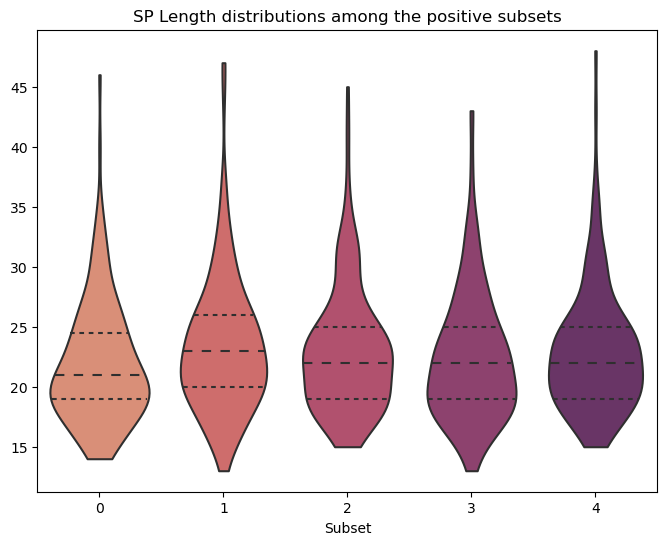

In [6]:
sp_len = []
for i in range(5):
    sp_len.append(pos_cv[i]['Signal peptide'])
plt.figure(figsize=(8, 6))
ax = sns.violinplot(data=sp_len, palette='flare', inner='quart', cut = 0).set(xlabel='Subset')
plt.title('SP Length distributions among the positive subsets')
plt.savefig("vonHeijne/figures/sp_len_cv_split.svg")

### 2. Training procedure

#### 2.1 Cross-Validation

In [7]:
validation_metrics = list()
testing_metrics = list()
column_names_pr = ['Run', 'Threshold', "Precision", "Recall",'F-score']
precision_recall_curves = pd.DataFrame(columns=column_names_pr)
column_names_rc = ['Run', 'Threshold','FPR', 'TPR']
roc_curves = pd.DataFrame(columns=column_names_rc)

for run in range(5):
    '''1. TRAINING '''
    training_set = pd.concat((pos_cv[(run+2)%5],pos_cv[(run+3)%5],pos_cv[(run+4)%5]),ignore_index=True)
    list_cleavage_sites = get_cleavage_sites(training_set)
    pswm = get_pswm(list_cleavage_sites)

    '''2. VALIDATION'''
    val_set = pd.concat((pos_cv[(run+1)%5],neg_cv[(run+1)%5]), ignore_index=True)
    validation_set = get_scores(pswm,val_set)

    # precision-recall curve values
    precision, recall, thresholds_pr = metrics.precision_recall_curve(validation_set['real_class'], validation_set['score'])
    # compute f-scores at varying thresholds
    fscore = (2 * precision * recall) / (precision + recall)
    #create a dataframe with the thresholds and the metrics
    pr = {'Run':run,'Threshold': thresholds_pr, 'Precision': precision[:-1], 'Recall': recall[:-1], 'F-score':fscore[:-1]}
    pr_testing_set = pd.DataFrame(pr)
    #update the global dataframe
    precision_recall_curves = pd.concat((precision_recall_curves,pr_testing_set),ignore_index=True)

    #OPTIMAL THRESHOLD / F-SCORE / PRECISION / RECALL
    # get the index of the maximum value of the f-score
    index = np.argmax(fscore)
    # retrieve the OPTIMAL THRESHOLD and F-SCORE corresponding to the max f-score computed above
    optimal_threshold = thresholds_pr[index]
    optimal_fscore = fscore[index]
    optimal_precision = precision[index]
    optimal_recall = recall[index]

    # roc curve values
    fpr, tpr, thresholds_roc = metrics.roc_curve(validation_set['real_class'],validation_set['score'], pos_label=1)
    roc_curve = {'Run':run,'Threshold':thresholds_roc, 'FPR':fpr,'TPR':tpr}
    roc_curve_testing_set = pd.DataFrame(roc_curve)
    #update the global dataframe
    roc_curves = pd.concat((roc_curves,roc_curve_testing_set),ignore_index=True)
    
    #ACC
    acc_val = metrics.accuracy_score(validation_set['real_class'],validation_set['score']>optimal_threshold)
    #MCC
    mcc_val = metrics.matthews_corrcoef(validation_set['real_class'],validation_set['score']>optimal_threshold)
    #CONFUSION MATRIX ([tn,fp][fn,fp])
    cm_val = metrics.confusion_matrix(validation_set['real_class'],validation_set['score']>optimal_threshold)
    #AUC
    auc_val = metrics.roc_auc_score(validation_set['real_class'],validation_set['score'])
    #update the global metrics list
    run_metrics_val = [run,optimal_threshold,acc_val,optimal_precision,optimal_recall,optimal_fscore,mcc_val,auc_val,cm_val]
    validation_metrics.append(run_metrics_val)
    

    '''3. TESTING'''
    test_set = pd.concat((pos_cv[run%5],neg_cv[run%5]),ignore_index=True)
    testing_set= get_scores(pswm,test_set)
    testing_set['pred_class'] = 0
    testing_set.loc[testing_set['score']>optimal_threshold,'pred_class'] = 1
    testing_set[['Entry','real_class','pred_class','score']].to_csv('vonHeijne/testing_results'+str(run)+'.tsv', sep='\t')
    
    #update the global metrics list
    run_metrics_test = get_metrics(testing_set,optimal_threshold)
    run_metrics_test = list(run_metrics_test)
    run_metrics_test.insert(0,run)
    run_metrics_test.insert(1,optimal_threshold)
    testing_metrics.append(run_metrics_test)


#####  2.1.1 Crossvalidation graphs and metrics

###### VALIDATION METRICS

In [8]:
#VALIDATION METRICS
validation_metrics = pd.DataFrame(validation_metrics, columns=['Run','Optimal threshold','Accuracy','Precision','Recall','F-score', 'MCC','AUC','CM'])
validation_metrics.to_csv('vonHeijne/validation_metrics.tsv',sep="\t")

###### TESTING METRICS

In [9]:
#TESTING METRICS
testing_metrics = pd.DataFrame(testing_metrics, columns=['Run','Optimal threshold','Accuracy','Precision','Recall','F-score', 'MCC','AUC','CM'])
testing_metrics.to_csv('vonHeijne/testing_metrics.tsv',sep="\t")


###### PRECISION RECALL CURVES

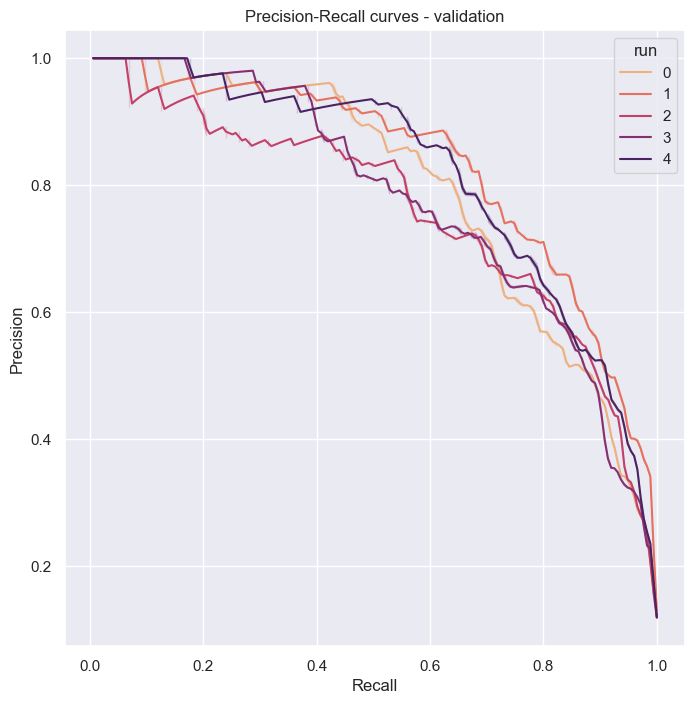

In [10]:
#PRECISION RECALL CURVES
sns.set(style="darkgrid")
plt.figure(figsize=(8, 8))

sns.lineplot(data=precision_recall_curves, x='Recall', y='Precision',hue='Run',palette='flare')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curves - validation')
plt.legend(title='run', loc='upper right')
plt.savefig('vonHeijne/figures/pr_curves.svg')



###### ROC CURVES

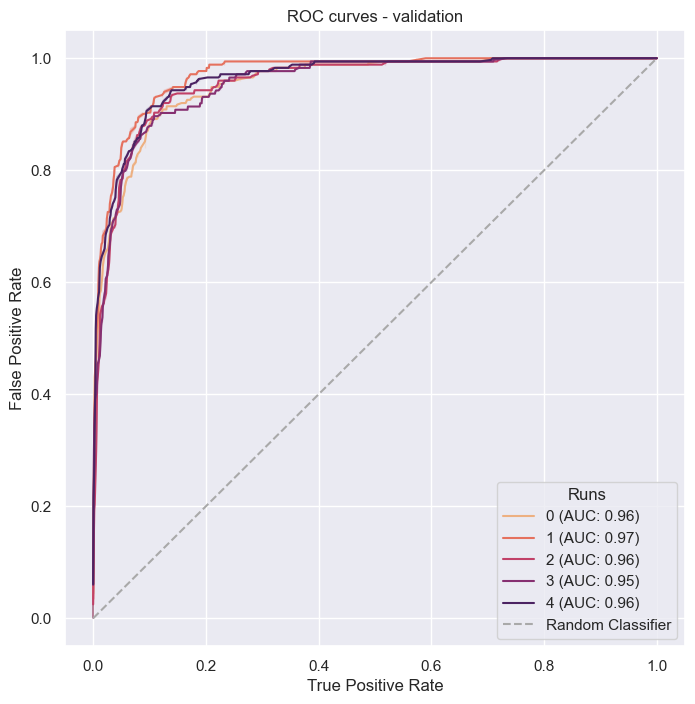

In [11]:

# Get unique runs and their corresponding AUC values
unique_runs = roc_curves['Run'].unique()
auc_values = validation_metrics.set_index('Run').loc[unique_runs, 'AUC']

# Format labels for ROC curves using a lambda function
format_label = lambda run: f'{run} (AUC: {auc_values[run]:.2f})'

# Add the "Random Classifier" label
labels = [format_label(run) for run in unique_runs] + ['Random Classifier']

# ROC CURVES
sns.set(style="darkgrid")
plt.figure(figsize=(8, 8))

ax = sns.lineplot(data=roc_curves, x='FPR', y='TPR', hue='Run', palette='flare')

# Plot the Random Classifier line
x = np.linspace(0, 1, 1000)
plt.plot(x, x, linestyle='--', color='darkgrey', label='Random Classifier')

plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.title('ROC curves - validation')

# Get the legend handles and update the labels and colors
handles, _ = ax.get_legend_handles_labels()
handles += [plt.Line2D([0], [0], color='darkgrey', linestyle='--')]  # Add the Random Classifier handle
ax.legend(handles=handles, labels=labels, title='Runs', loc='lower right')

plt.savefig('vonHeijne/figures/roc_curves_validation.svg')



##### 2.1.3 Computation of the average threshold and comparison of the performances between validation and testing

Now we compute the average values, particularly the average of the threshold will be the threshold used during the training part.
It is useful to compute these average both for the validation and the testing metrics, in order to see wheter there are important differences.

In [12]:
avg_testing_metrics = avg_sem(testing_metrics)
avg_validation_metrics = avg_sem(validation_metrics)
avg_metrics = pd.concat((avg_validation_metrics,avg_testing_metrics),keys=['validation','testing'],axis=1)
avg_metrics.columns = avg_metrics.columns.droplevel(level=1)



#### 2.2 Training on the whole trainining dataframe

In [13]:
lst_CV = get_cleavage_sites(positives_train)
pswm = get_pswm(lst_CV)
#print(pswm)
format_specifier = "%.2f"
np.savetxt('vonHeijne/pswm.csv', pswm, fmt=format_specifier, delimiter='\t')


##### weighted matrix heatmap
this confusion matrix needs also to be saved as txt file.

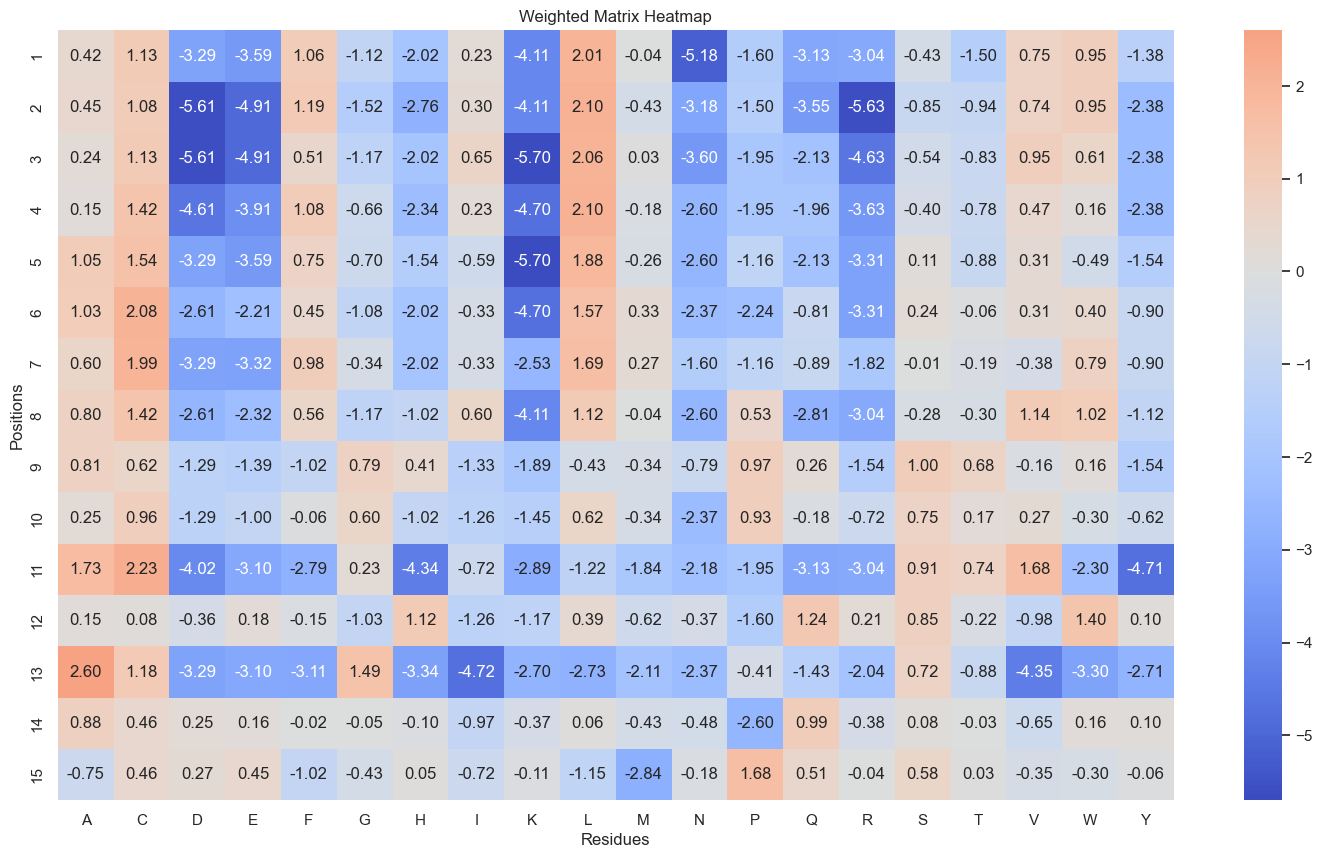

In [14]:
# Create a Seaborn heatmap
sns.set(style="whitegrid")
plt.figure(figsize=(18, 10))  # Set the figure size

# Create the heatmap
sns.heatmap(pswm, cmap="coolwarm", center=0, annot=True, fmt=".2f", cbar=True)

residue_labels = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
position_labels =  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


plt.xlabel("Residues")
plt.ylabel("Positions")
plt.title("Weighted Matrix Heatmap")
plt.xticks(np.arange(len(residue_labels)) + 0.5, residue_labels)
plt.yticks(np.arange(len(position_labels)) + 0.5, position_labels)
plt.savefig('vonHeijne/figures/weighted_matrix.svg')


### 3. Testing and performance evaluation

In [15]:

benchmarking_set = get_scores(pswm,benchmarking)
benchmarking_metrics = get_metrics(benchmarking_set,optimal_threshold)
benchmarking_metrics = pd.DataFrame([benchmarking_metrics], columns=['Accuracy','Precision','Recall','F-score', 'MCC','AUC','CM'])
benchmarking_metrics.insert(0,'Optimal threshold',np.round(testing_metrics['Optimal threshold'].mean(),decimals=2))
benchmarking_metrics = benchmarking_metrics.round(2)
benchmarking_metrics.iloc[:,:-1].to_csv('vonHeijne/benchmarking_metrics.csv', sep='\t',index=False)
benchmarking_set[['Entry','real_class','pred_class','score']].to_csv('vonHeijne/benchmarking_results.tsv', sep='\t')
benchmarking_metrics
    

,Optimal threshold,Accuracy,Precision,Recall,F-score,MCC,AUC,CM
0,9.06,0.94,0.66,0.82,0.73,0.7,0.97,"[[1811, 94], [39, 180]]"


#### 3.1 Confusion matrix

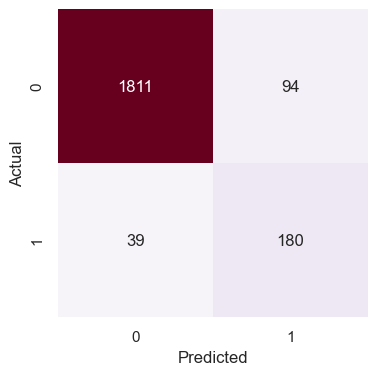

In [16]:
confusion_matrix = benchmarking_metrics.at[0,'CM']
plt.figure(figsize=(4, 4))
cm_plot = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap='PuRd', cbar=False)
cm_plot.tick_params(left=False, bottom=False)
cm_plot.set(xticklabels=['0', '1'],yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('vonHeijne/figures/confusion_matrix2.svg', bbox_inches='tight')

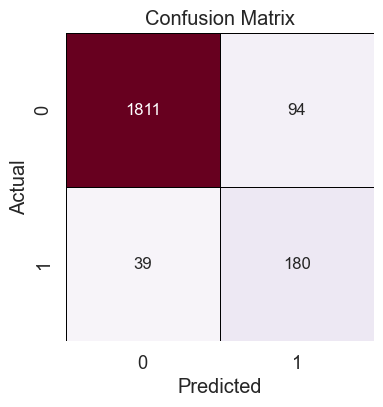

In [17]:
confusion_matrix = benchmarking_metrics.at[0,'CM']
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.2)  # Adjust the font size if needed
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='PuRd', cbar=False,
            annot_kws={"size": 12}, square=True, linewidths=0.5, linecolor='black')

# Add labels and a title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.savefig('vonHeijne/figures/confusion_matrix.svg')


#### 3.2 Comparison training VS benchmarking metrics

In [18]:
metrics_comparison = pd.concat((avg_testing_metrics,benchmarking_metrics.iloc[:,:-1].transpose()),keys=['testing','benchmarking'],axis=1)
metrics_comparison.columns = metrics_comparison.columns.droplevel(level=1)
metrics_comparison=metrics_comparison.transpose()
metrics_comparison.to_csv('vonHeijne/metrics_comparison.csv', sep='\t',index=False)
metrics_comparison


,Optimal threshold,Accuracy,Precision,Recall,F-score,MCC,AUC
testing,9.06 ± 0.31,0.94 ± 0.00,0.70 ± 0.04,0.72 ± 0.04,0.70 ± 0.01,0.67 ± 0.01,0.96 ± 0.00
benchmarking,9.06,0.94,0.66,0.82,0.73,0.7,0.97


### 4. Analysis of false positives

extract metadata from benchmarking. from negative eamples, from the cm we can compute the false positive rates (how many nehatives are predicted as positives). thus we can take all the negatives, go to uniprot and extract 3 info (checking also the eco code):
- presence of at least transmembrane sequence (if 90 was used) in the first 90 residues => transmembrane protein can be a source of misclassification 
- presence of different targeting signals (transit peptide(tow mithocondria and chloroplast or peroxisomes)), ith experimental evidence.


obtained this, we can compute 4 additiona false pos rate:
- in tranm = subset of trans fp / transmemrbane
- same for the transit peptide (you can do a general one): fp(transit p)/transit

#### False Positive Rate

In [19]:
### False positive rate (FP/FP+TN)
benchmarking_metrics.at[0,'CM']
tn = benchmarking_metrics.at[0,'CM'][0,0]
fp = benchmarking_metrics.at[0,'CM'][0,1]
fpr = np.round((fp/(tn+fp))*100,decimals=3)
print('FPR: %s' % (fpr)+'%')

FPR: 4.934%


#### False Positive Rate Transmembrane - Transit peptide

##### 1. Identification of transmembrane proteins and proteins characterized by the transit peptide by using programmatic access

Firstly, by using **json** we identified all the proteins within the negatives that were characterized by the presence of a transmembrane element or a transit peptide (or both) on UniProt Swissprot. We are interested only in the one manually curated with respect to these features.

In [20]:
from pip._vendor import requests
import sys
import json
eco_lst = ['ECO:0000269', 'ECO:0000303', 'ECO:0000305', 'ECO:0000250', 'ECO:0000255', ' ECO:0000312', ' ECO:0007744']


In [21]:

#def get_json_by_accession(accession):
#        requestURL = "https://www.ebi.ac.uk/proteins/api/proteins/%s" % accession
#
#        r = requests.get(requestURL, headers={ "Accept" : "application/json"})
#        if not r.ok:
#            r.raise_for_status()
#
#        json_body = r.json()
#        return json_body 
#
##save the json in a file text
#with open('negatives/neg_benchmarking', 'r') as f1, open('vonHeijne/fp_analysis/neg_json','x') as f2:
#    for entry in f1:
#        entry = entry.rstrip()
#        json_data = get_json_by_accession(entry)
#        f2.write(json.dumps(json_data)  +'\n')


#### 1.1 Transmembrane proteins

In [22]:
with open('vonHeijne/fp_analysis/neg_json') as f1, open('vonHeijne/fp_analysis/neg_transmem','w') as f2:
    for line in f1:
        line = line.rstrip()
        data = json.loads(line)
        valid_tm = False
        for item in data['features']:  
            if valid_tm: break  
            elif item['type'] == 'TRANSMEM' and item['begin'] == '<1':
                try:
                    for e in item['evidences']:
                       evidences = set([e["code"]])
                       if len(evidences.intersection(eco_lst)) > 0:
                            valid_tm = True 
                            f2.write(data['accession']+'\n')   
                            #print(data['accession'])
                            break                      
                except KeyError:
                    print(data['accession']+' '+ 'has no ECO code'+'\n')
            elif item['type'] == 'TRANSMEM' and int(item['begin']) < 90:               
                try:
                   for e in item['evidences']:
                        evidences = set([e["code"]])
                        if len(evidences.intersection(eco_lst)) > 0:
                            valid_tm = True  
                            f2.write(data['accession']+'\n')
                            #print(data['accession'])  
                            break   
                except KeyError:
                    print(data['accession']+' '+ 'has no ECO code'+'\n')
            

P04921 has no ECO code



#### 1.2 Transit peptide

In [23]:
with open('vonHeijne/fp_analysis/neg_json') as f1, open('vonHeijne/fp_analysis/neg_transit', 'w') as f2:
    for line in f1:
        line = line.rstrip()
        data = json.loads(line)
        valid_transit = False
        for item in data['features']:
            if valid_transit: break  
            elif item['type'] == 'TRANSIT' and item['begin'] == '<1':
                try:
                    for e in item['evidences']:
                       evidences = set([e["code"]])
                       if len(evidences.intersection(eco_lst)) > 0:
                            valid_transit = True    
                            f2.write(data['accession']+'\t'+item['description']+'\n')
                            #print(data['accession']+' '+ e['code']+' '+item['description'])
                            break                      
                except KeyError:
                    print(data['accession']+' '+ 'has no ECO code'+'\n')
            elif item['type'] == 'TRANSIT' and int(item['begin']) < 90:               
                try:
                   for e in item['evidences']:
                        evidences = set([e["code"]])
                        if len(evidences.intersection(eco_lst)) > 0:
                            valid_transit= True
                            f2.write(data['accession']+'\t'+item['description']+'\n')  
                            #print(data['accession']+' '+ e['code']+' '+item['description'])  
                            break   
                except KeyError:
                    print(data['accession']+' '+ 'has no ECO code'+'\n')
            
        

P12354 has no ECO code

P30815 has no ECO code

P40513 has no ECO code

P19824 has no ECO code

P31336 has no ECO code

Q43082 has no ECO code

P05066 has no ECO code

Q9VUF8 has no ECO code

Q8L4R0 has no ECO code

Q9UGC7 has no ECO code

P11178 has no ECO code



In [24]:
### create a dataframe containing all the negative in the benchmaring dataset
benchmarking_neg = benchmarking_set[benchmarking_set['real_class']==0][['Entry','pred_class']]
benchmarking_neg['TM'] = 'non-transmembrane'
benchmarking_neg.to_csv('vonHeijne/negatives_bench_results.tsv',sep='\t',index=False)


In [25]:
### uptade the dataframe
with open('vonHeijne/fp_analysis/neg_transmem') as file:
    tm_subset = [line.strip() for line in file]
    benchmarking_neg.loc[benchmarking_neg['Entry'].isin(tm_subset), 'TM'] = 'transmembrane'


In [26]:

tp_subset = pd.read_table('vonHeijne/fp_analysis/neg_transit',sep='\t',names=['Entry','TP_location'])
benchmarking_neg = pd.merge(benchmarking_neg,tp_subset,on='Entry',how = 'outer')
benchmarking_neg.insert(loc=3, column='TP', value='no transit peptide')
benchmarking_neg.loc[benchmarking_neg['TP_location'].notna(), 'TP'] = 'transit peptide'


In [27]:
benchmarking_neg[benchmarking_neg['TP'] == 'transit peptide']

,Entry,pred_class,TM,TP,TP_location
9,Q9ZST9,0,non-transmembrane,transit peptide,Chloroplast
11,Q8R107,0,non-transmembrane,transit peptide,Mitochondrion
13,Q9LK39,1,non-transmembrane,transit peptide,Chloroplast
17,Q6NLC1,0,transmembrane,transit peptide,Chloroplast
22,Q9NZE8,0,non-transmembrane,transit peptide,Mitochondrion
...,...,...,...,...,...
1847,Q8IVH4,0,non-transmembrane,transit peptide,Mitochondrion
1851,Q9SJU9,1,non-transmembrane,transit peptide,Chloroplast
1863,Q1MTN7,0,non-transmembrane,transit peptide,Mitochondrion
1881,Q9M8D3,0,non-transmembrane,transit peptide,Chloroplast and mitochondrion


##### False positive rate - transmembrane proteins

In [28]:
### FPR_TM
tm_FP = benchmarking_neg[(benchmarking_neg['TM']=='transmembrane') & (benchmarking_neg['pred_class']==1)].shape[0]
tm = benchmarking_neg[(benchmarking_neg['TM']=='transmembrane')].shape[0]
FPR_tm =np.round((tm_FP/tm)*100,decimals=2)
print('FPR_TM: %s' % (FPR_tm)+'%')

FPR_TM: 26.85%


##### False positive rate - transit peptide

In [29]:
### FPR_TP
tp_FP = benchmarking_neg[(benchmarking_neg['TP']=='transit peptide') & (benchmarking_neg['pred_class']==1)].shape[0]
tp = benchmarking_neg[(benchmarking_neg['TP']=='transit peptide')].shape[0]
FPR_tp =np.round((tp_FP/tp)*100,decimals=1)
print('FPR_TP: %s' % (FPR_tp)+'%')

FPR_TP: 7.9%


#### FPR_TM and FPR_TP visualization

In [30]:
benchmarking_neg.loc[benchmarking_neg['pred_class'] == 1,'pred_class']='FP'
benchmarking_neg.loc[benchmarking_neg['pred_class'] == 0,'pred_class']='TN'

In [31]:

transmem_df = benchmarking_neg[benchmarking_neg['TM']=='transmembrane'][['pred_class','TM']]
transmem_df['feature'] = 'Transmembrane'
#
transit_df = benchmarking_neg[benchmarking_neg['TP']=='transit peptide'][['pred_class','TP']]
transit_df['feature'] = 'Transit peptide'
#
tm_tp = pd.concat((transmem_df[['pred_class','feature']],transit_df[['pred_class','feature']]),ignore_index=True)
tm_tp

,pred_class,feature
0,TN,Transmembrane
1,TN,Transmembrane
2,TN,Transmembrane
3,TN,Transmembrane
4,TN,Transmembrane
...,...,...
360,TN,Transit peptide
361,FP,Transit peptide
362,TN,Transit peptide
363,TN,Transit peptide


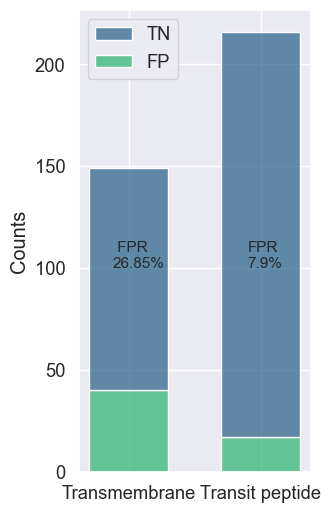

In [32]:

plt.figure(figsize=(3, 6))
ax = sns.histplot(data=tm_tp,x = 'feature',hue='pred_class',stat='count',multiple='stack',common_norm=False,shrink=0.6, palette='viridis')
sns.move_legend(ax, title='', loc= 'upper left')
plt.xlabel('')
plt.ylabel('Counts')
plt.text(-0.12, 100, f' FPR\n{FPR_tm}%', fontsize=11)
plt.text(0.9, 100, f'FPR\n{FPR_tp}%', fontsize=11)
#plt.title('FPR - transmembrane proteins and proteins with transit peptide')
plt.savefig("vonHeijne/figures/FPR_TMandFPR_TP.svg",bbox_inches='tight')


#### Over-representation of transmembrane proteins in FP with respect to TN

In [33]:
pivot_df = benchmarking_neg.pivot_table(index='pred_class', columns='TM', values='Entry', aggfunc='count', fill_value=0)
columns_titles = ['transmembrane',"non-transmembrane"] #change cols order
pivot_df = pivot_df.reindex(columns=columns_titles)
odds_ratio, p_value1 = fisher_exact(pivot_df)
p_value1 = '{:0.2e}'.format(p_value1)



11.566428814135236

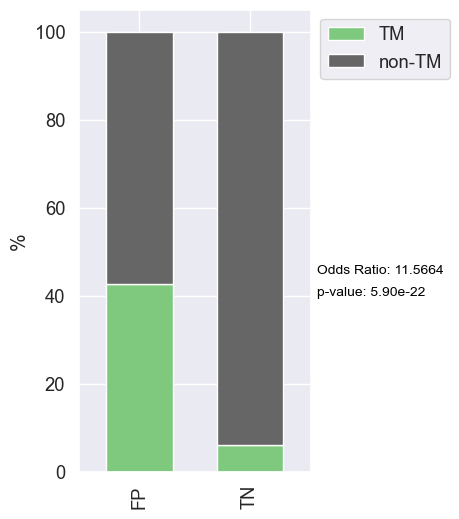

In [34]:
pivot_df['Total'] = pivot_df['transmembrane'] + pivot_df['non-transmembrane']
pivot_df['transmembrane_Percentage'] = (pivot_df['transmembrane'] / pivot_df['Total']) * 100
pivot_df['non_transmembrane_Percentage'] = (pivot_df['non-transmembrane'] / pivot_df['Total']) * 100
pivot_df
# Create the stacked barplot
plt.rcParams['figure.figsize'] = [3, 6]
pivot_df[['transmembrane_Percentage', 'non_transmembrane_Percentage']].plot(kind='bar', stacked=True, colormap='Accent',width=0.6)
#plt.title('TM by classes')
plt.xlabel('')
plt.ylabel('%')
#plt.legend(title='TM', loc='upper right', labels=['transmembrane', 'non-transmembrane'])
 
plt.legend(['TM','non-TM'],bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.text(1.6, 40, f'p-value: {p_value1}', fontsize=10, color='black')
plt.text(1.6, 45, f'Odds Ratio: {odds_ratio:.4f}', fontsize=10, color='black')

pivot_df
plt.savefig("vonHeijne/figures/enrichmentTM_VH.svg",bbox_inches='tight')


odds_ratio

#### Over-representation of transit peptide proteins in FP with respect to TN

In [35]:

pivot_df2 = benchmarking_neg.pivot_table(index='pred_class', columns='TP', values='Entry', aggfunc='count', fill_value=0)
#
columns_titles = ['transit peptide',"no transit peptide"]
pivot_df2=pivot_df2.reindex(columns=columns_titles)
odds_ratio, p_value = fisher_exact(pivot_df2)



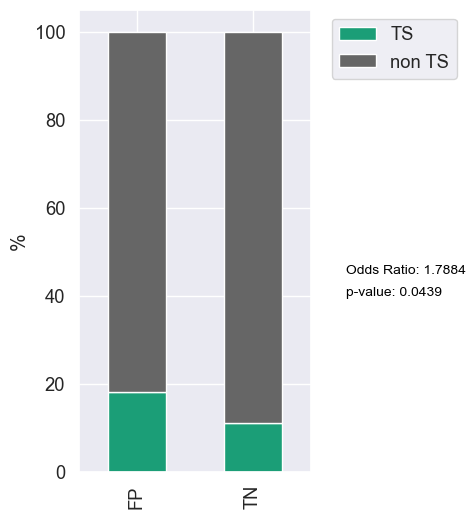

In [36]:
pivot_df2['Total'] = pivot_df2['transit peptide'] + pivot_df2['no transit peptide']
pivot_df2['transit peptide_Percentage'] = (pivot_df2['transit peptide'] / pivot_df2['Total']) * 100
pivot_df2['Non_Transit-peptide_Percentage'] = (pivot_df2['no transit peptide'] / pivot_df2['Total']) * 100
plt.rcParams['figure.figsize'] = [3, 6]
pivot_df2[['transit peptide_Percentage', 'Non_Transit-peptide_Percentage']].plot(kind='bar', stacked=True, colormap='Dark2')
#plt.title('TP by classes')
plt.xlabel('')
plt.ylabel('%')
plt.legend(['TS','non TS'],bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.text(1.8, 40, f'p-value: {p_value:.4f}', fontsize=10, color='black')
plt.text(1.8, 45, f'Odds Ratio: {odds_ratio:.4f}', fontsize=10, color='black')
plt.savefig("vonHeijne/figures/TSenrichment_VH.svg",bbox_inches='tight')


Text(0, 0.5, 'subcellular location')

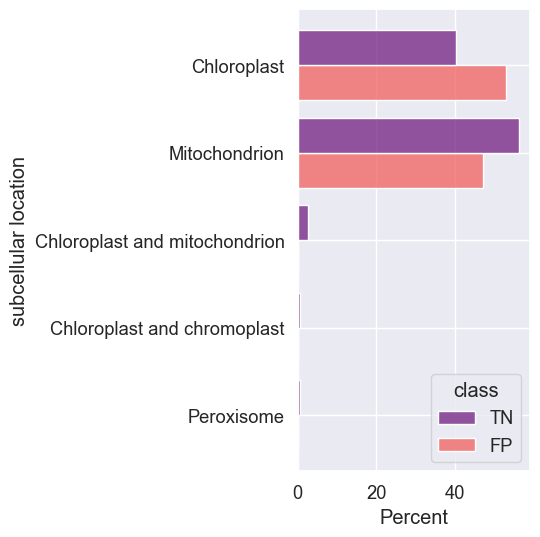

In [37]:

tp_df = benchmarking_neg[benchmarking_neg['TP']=='transit peptide']
ax = sns.histplot(data=tp_df,hue='pred_class',y = 'TP_location',stat='percent',multiple='dodge',common_norm=False,shrink=0.8,palette='magma')
sns.move_legend(ax, loc = 'lower right', title='class')
plt.ylabel('subcellular location')

### 5. FALSE NEGATIVE ANALYSIS

For the von-Heijne method, FNs may be due to a different composition of the cleavage-site context than expected:

    ○ For all FN in the benchmark, we can compute the corresponding LOGO and compare it with the expected one

In [38]:
### False negative rate (FN/FN+TP) or miss rate
#benchmarking_metrics.at[0,'CM']
fn = benchmarking_metrics.at[0,'CM'][1,0]
tp = benchmarking_metrics.at[0,'CM'][1,1]
fnr = np.round((fn/(tp+fn))*100,decimals=3)
print('FNR: %s' % (fnr)+'%')

FNR: 17.808%


In [39]:
benchmarking_neg

,Entry,pred_class,TM,TP,TP_location
0,Q9H444,TN,non-transmembrane,no transit peptide,NaN
1,Q8S8D3,TN,non-transmembrane,no transit peptide,NaN
2,Q9FG00,TN,transmembrane,no transit peptide,NaN
3,P82929,TN,non-transmembrane,no transit peptide,NaN
4,Q00IB6,TN,non-transmembrane,no transit peptide,NaN
...,...,...,...,...,...
1900,G5EGF8,TN,non-transmembrane,no transit peptide,NaN
1901,Q8WXI9,TN,non-transmembrane,no transit peptide,NaN
1902,Q3EBC8,TN,non-transmembrane,no transit peptide,NaN
1903,Q8I615,TN,non-transmembrane,no transit peptide,NaN


In [40]:
#create a dataframe containing only the FN 
fn_dataframe = benchmarking_set[(benchmarking_set['real_class'] == 1) & (benchmarking_set['pred_class']==0)]
#get the cleavage sites and use them to create the sequence logo 
fn_cleavsites = get_cleavage_sites(fn_dataframe)
#save the cleavage sites in a file to upload on WebLogo
with open('vonHeijne/fn_analysis/cleavage_sites_false_negatives.txt', 'w') as f:
    for cleavage_site in fn_cleavsites:
        f.write(cleavage_site+'\n')


False negatives logo

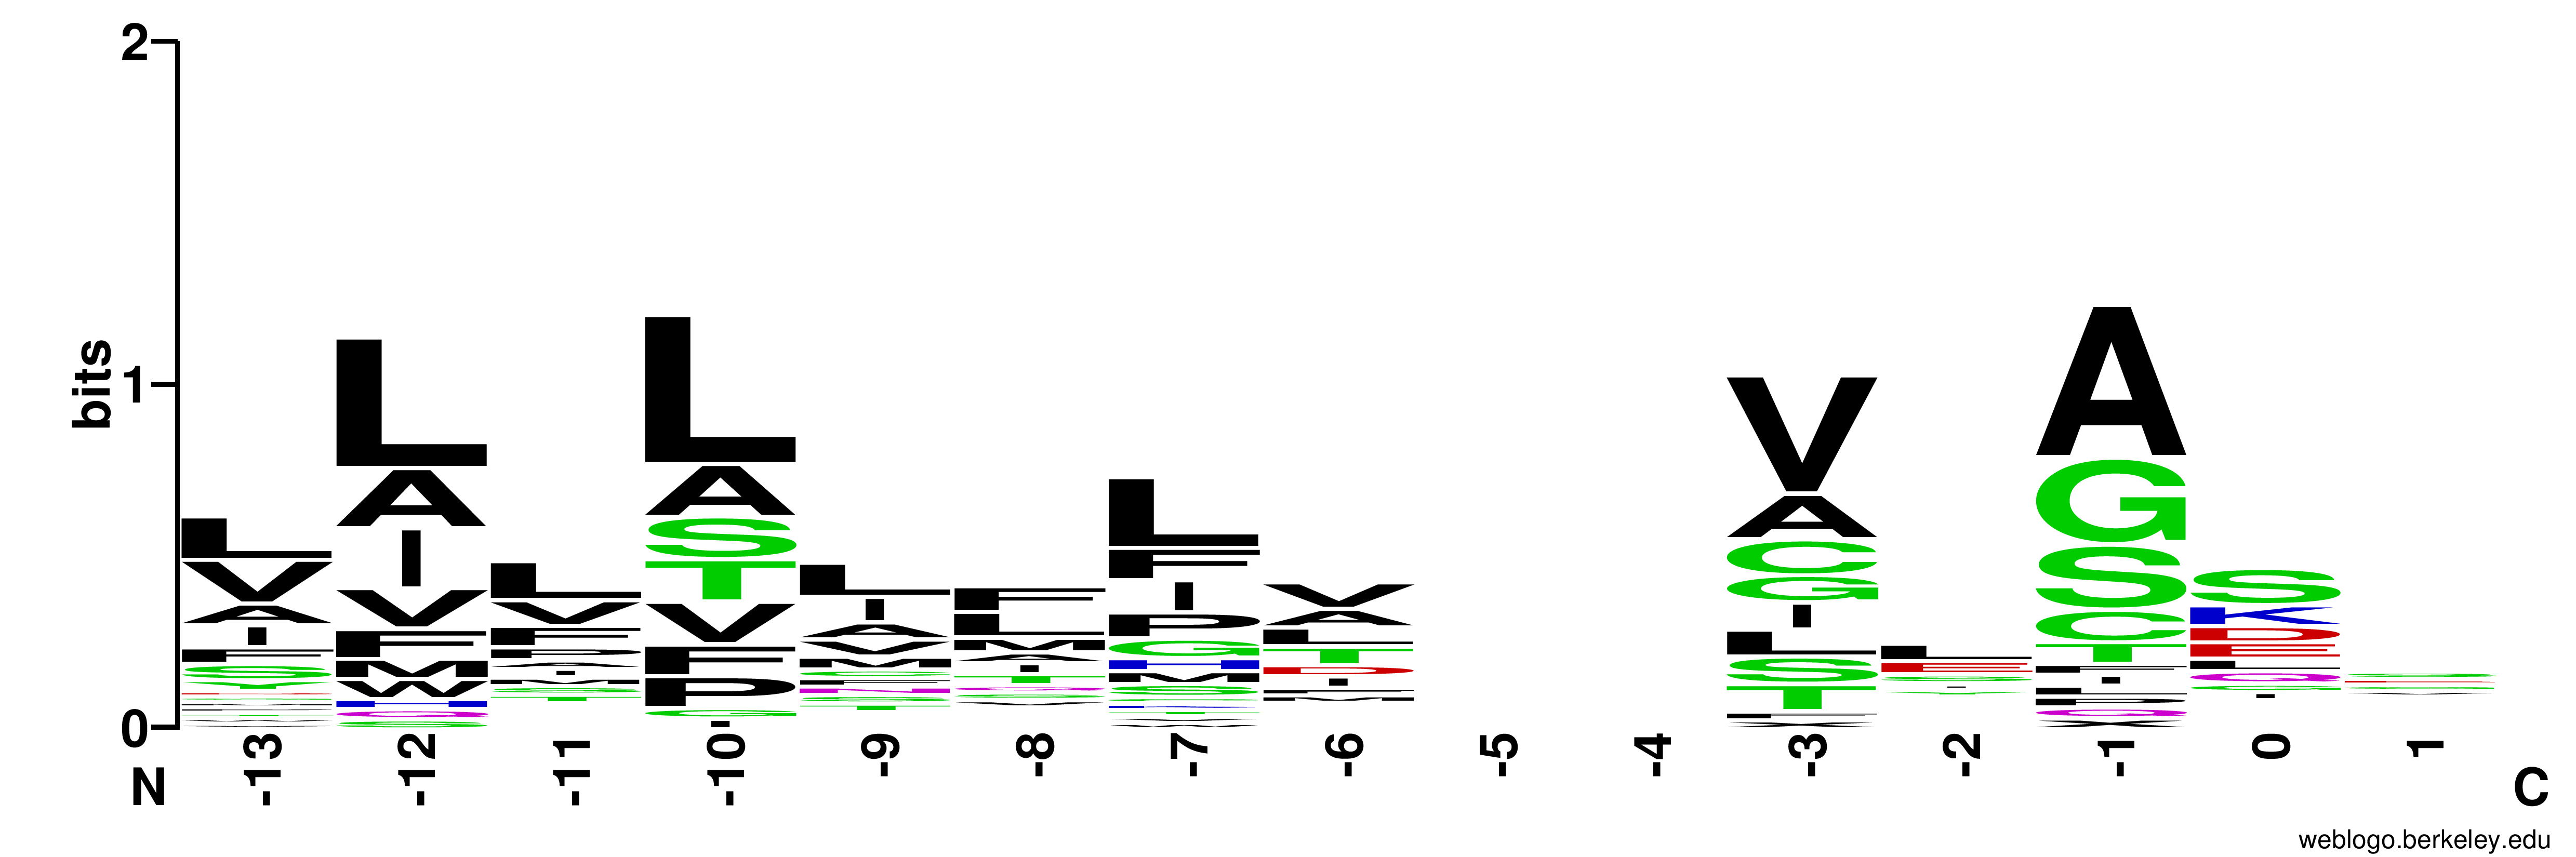

In [41]:
tm_tp[tm_tp['feature']=='Transmembrane']

,pred_class,feature
0,TN,Transmembrane
1,TN,Transmembrane
2,TN,Transmembrane
3,TN,Transmembrane
4,TN,Transmembrane
...,...,...
144,FP,Transmembrane
145,TN,Transmembrane
146,FP,Transmembrane
147,TN,Transmembrane
